# Association rule mining using OSM Data: Large Rules

Within this notebook, an association rule analysis is performed using OSM data. 

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import ohsome
import nb_utils as nbu

Pyproj throws a lot of deprecation warnings within geopandas at the moment, since the functions have not been updated yet. Therefore, warning are suppressed.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

## Input paths and configuration parameters

In [4]:
data_dir = "../data"
figures_dir = "../figures"
tables_dir = "../tables"
interim_dir = "../interim_results"
config_file = "../config/parks.yaml"

Cities under investigation:

In [5]:
cities = ["dresden", "berlin", "london", "telaviv", "tokyo", "osaka", "newyork", "vancouver"]

Create output directories

In [6]:
if not os.path.exists(figures_dir):
    os.mkdir(figures_dir)
if not os.path.exists(tables_dir):
    os.mkdir(tables_dir)
if not os.path.exists(interim_dir):
    os.mkdir(interim_dir)

Read config parameters

In [7]:
config_cities = nbu.load_config(config_file, cities)
city_labels = {city: config_cities[city]["name"] for city in cities}

## Import data

Import the preprocessed data extracted using the ohsome API.

In [8]:
all_features = nbu.load_data(cities, data_dir)

Loading dresden...
Loading berlin...
Loading london...
Loading telaviv...
Loading tokyo...
Loading osaka...
Loading newyork...
Loading vancouver...


# Association Rule Analysis

The size of the associtation rules was limited to 2, since larger rules usually do not exceed the minimum support value of 5%.

In [9]:
MAX_RULE_SIZE = 10
MIN_SUPPORT = 0.05
MIN_CONFIDENCE = 0.7
MIN_LIFT = 1.5
MIN_FEATURES = 100

## 1. General Association Rule Analysis

With in the first general association rule analysis, association rules are calculated based on all parks within each city. in the first step, __all association rules between items are calculated__. At this step, the rules are already __filtered based on the minimum support value of 5%.__

In [10]:
rules_all, labels_all = nbu.generate_association_rules(all_features, MAX_RULE_SIZE, MIN_SUPPORT, city_labels)

dresden: 467 features
berlin: 1390 features
london: 1578 features
telaviv: 1168 features
tokyo: 2670 features
osaka: 1022 features
newyork: 893 features
vancouver: 552 features


### Number of rules by size per city

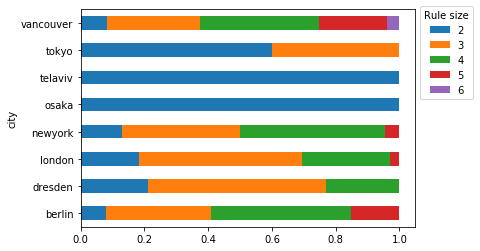

In [11]:
rule_size_by_city, rule_size_by_city_perc = nbu.rule_size_chart(rules_all)

In [12]:
rules_all["city"].value_counts()

berlin       3570
vancouver    3094
london        964
dresden       730
newyork       648
tokyo          30
telaviv        16
osaka           6
Name: city, dtype: int64

### Filter rules
To limit the number of association rules to be analyzed, rules of size 3 an larger are filtered by comparing them to rules of size 2. If a rule of size 2 existis whose confidence value is less than 10 percent lower than the large rule, the large rule is dismissed. 

In [13]:
filtered_rules = nbu.filter_rules(rules_all, cities)

dresden
berlin
london
telaviv
tokyo
osaka
newyork
vancouver


In [14]:
len(filtered_rules)

5153

__Conclusion:__ 
* Rules of size 3 and higher are only becoming relevant in cities with parks overlapping many mapped objects (e.g. Vancouver).

### Heatmap of interesting rules

In a second step, __interesting rules are selected__ based on minimum confidence ```MIN_CONFIDENCE``` and minimum lift ```MIN_LIFT``` of single cities.

In [15]:
heatmap_df_all, interesting_rules_all = nbu.select_interesting_rules(rules_all, MIN_CONFIDENCE, MIN_LIFT)

Association rules are additionally filtered by only including rules which appear in a minimum number of cities and which reach a minimum confidence and lift value in all cities.

In [16]:
min_confidence_all_cities = 0.7
min_lift_all_cities = 1.1
valid_in_cities = 2
heatmap_df_all_plt = heatmap_df_all.loc[(heatmap_df_all["lift"].min(axis=1) >= min_lift_all_cities) & 
                            (heatmap_df_all["confidence"].min(axis=1) >= min_confidence_all_cities) & 
                            (heatmap_df_all["confidence"].notna().sum(axis=1) >= valid_in_cities)]

Finally, associtiation rules are plotted as a heatmap.

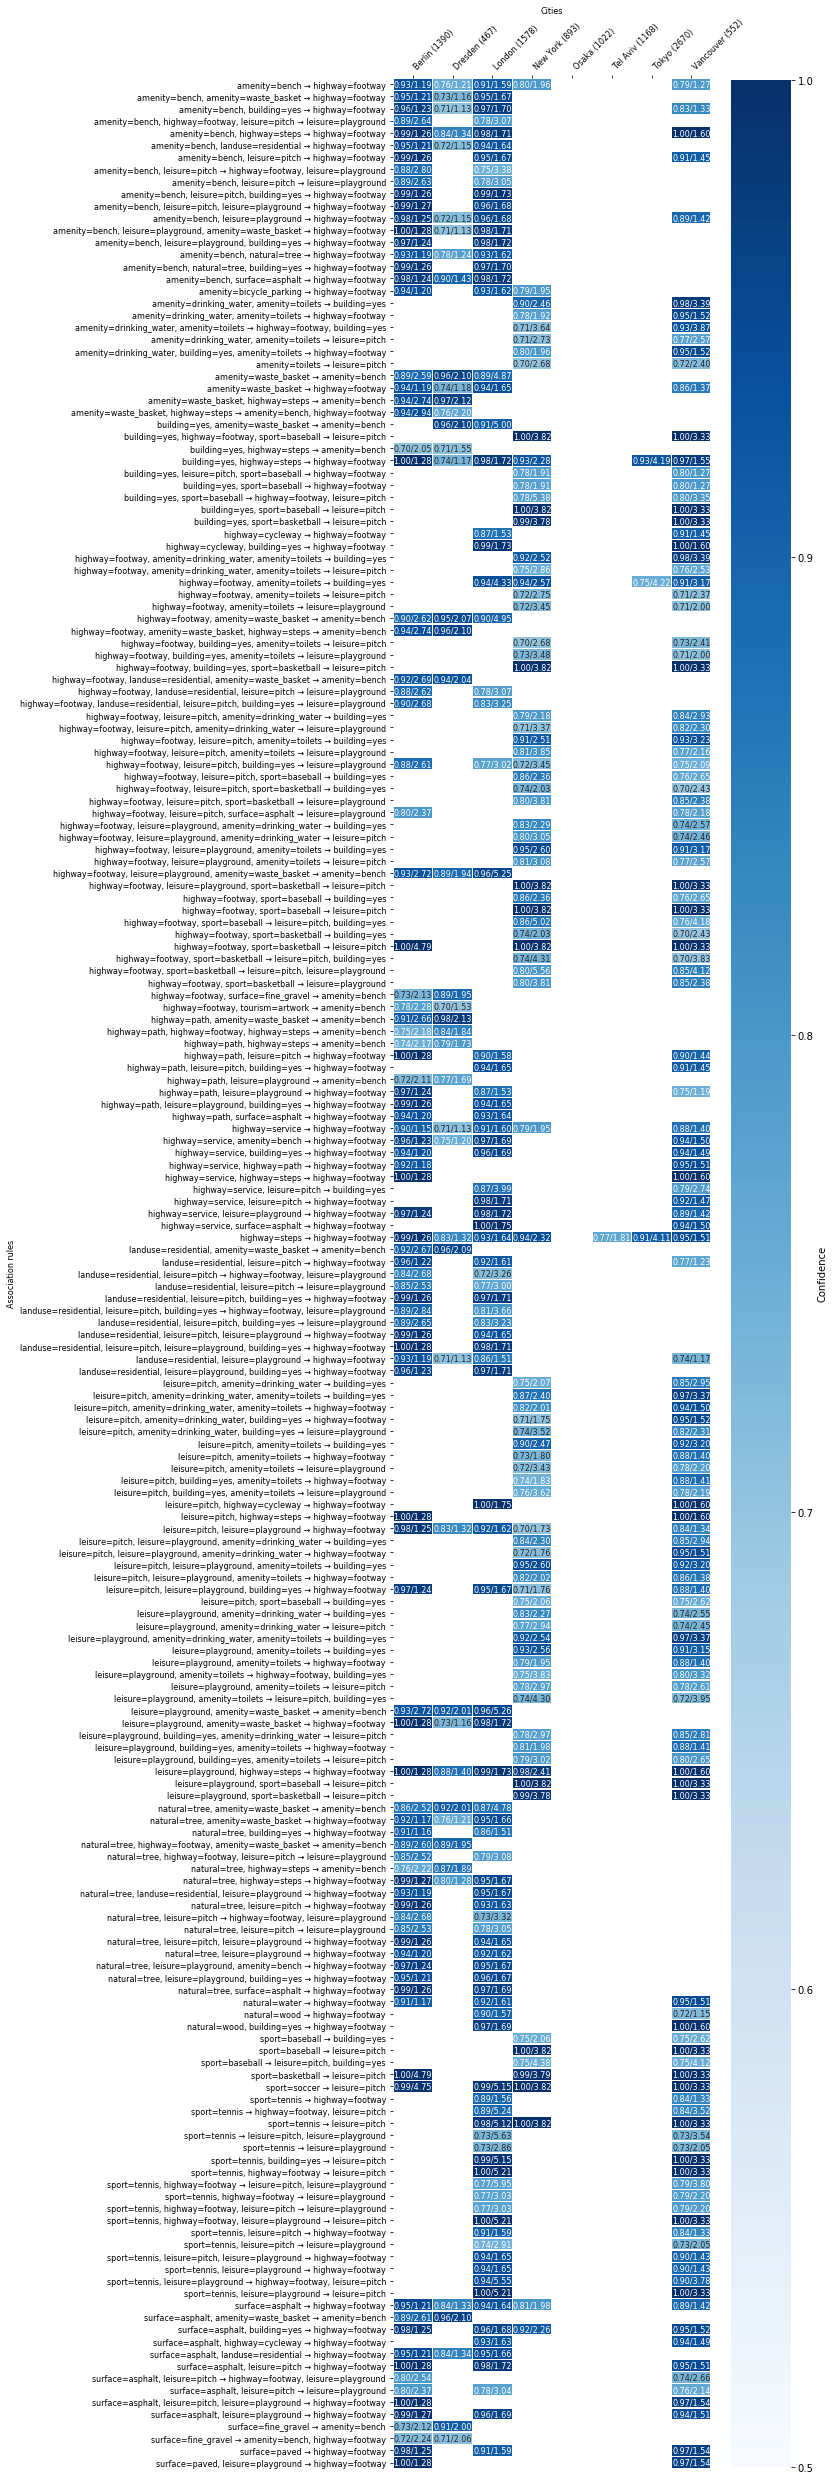

In [17]:
nbu.plot_rule_heatmap(heatmap_df_all_plt, labels=labels_all, left=0.35, top=0.88, vmin=0.5, vmax=1, figsize=(8.5,40), fontsize=8)
#plt.savefig(os.path.join(figures_dir, "figure_3.pdf"), dpi=600, layout="tight")

In [18]:
rules_all.loc[rules_all.apply(lambda x: (x["antecedents"] == ['sport=tennis']) & 
                             (x["consequents"] == ['leisure=pitch','highway=footway']), axis=1)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,interest,rule,city,size


In [19]:
rules_all.loc[rules_all.apply(lambda x: (x["antecedents"] == ['sport=tennis']) & 
                             (x["consequents"] == ['leisure=pitch']), axis=1)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,interest,rule,city,size
200,[sport=tennis],[leisure=pitch],0.075412,0.192015,0.074144,0.983193,5.120393,0.059664,48.075095,0.791178,sport=tennis → leisure=pitch,london,2
104,[sport=tennis],[leisure=pitch],0.058231,0.262038,0.058231,1.000000,3.816239,0.042972,inf,0.737962,sport=tennis → leisure=pitch,newyork,2
258,[sport=tennis],[leisure=pitch],0.121377,0.300725,0.121377,1.000000,3.325301,0.084876,inf,0.699275,sport=tennis → leisure=pitch,vancouver,2
